## Clutch Hitting
Import the data and Define some functions

In [1]:
#Import libraries and s
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Column reference:
# https://baseballsavant.mlb.com/csv-docs

#Import Data
#Read in the Statcast Data - note this is around 4GB of data!
stat_15 = pd.read_csv('../data/external/statcast_15.zip', parse_dates=['game_date'])
stat_16 = pd.read_csv('../data/external/statcast_16.zip', parse_dates=['game_date'])
stat_17 = pd.read_csv('../data/external/statcast_17.zip', parse_dates=['game_date'])
stat_18 = pd.read_csv('../data/external/statcast_18.zip', parse_dates=['game_date'])
stat_19 = pd.read_csv('../data/external/statcast_19.zip', parse_dates=['game_date'])
stat_20 = pd.read_csv('../data/external/statcast_20.zip', parse_dates=['game_date'])

#Combine the data into a single dataframe
stat_years_combined_list = [
    stat_15, 
    stat_16, 
    stat_17, 
    stat_18, 
    stat_19,
    stat_20
]

stat_years_combined_df = pd.concat(
    stat_years_combined_list, 
    ignore_index=True
)

#Split out years
stat_years_combined_df['year'] = stat_years_combined_df[
    'game_date'
].apply(lambda x: x.strftime('%Y'))

#Subset for what I need
stat_comb = stat_years_combined_df[
    ['index', 
     'game_date',
     'year',
     'batter',
     'pitcher',
     'player_name',
     'events',
     'game_type',
     'home_team',
     'away_team',
     'home_score',
     'away_score',
     'bat_score',
     'fld_score',
     'on_1b',
     'on_2b',
     'on_3b',
     'post_home_score',
     'post_away_score',
     'inning',
     'hit_distance_sc',
     'launch_speed',
     'launch_angle',
     'launch_speed_angle',
     'effective_speed',
     'release_speed',
     'release_spin_rate',
     'estimated_ba_using_speedangle',
     'estimated_woba_using_speedangle',
     'pitch_name'
    ]
]

#add_player names
names = pd.read_csv('../data/external/name_master.csv', encoding = "utf-8")
#names.columns

print('Data imported successfully.\nFormatting and cleaning data...')

#Get we want regular season games:
stat_comb = stat_comb[stat_comb.game_type == 'R']

#Convert NaN to zero for the on-base colums=ns
values = {'on_1b':0,'on_2b':0,'on_3b':0}
stat_comb.fillna(value=values, inplace=True)

#Replace the playerID with an integer for the 1,2 and 3b colums:
stat_comb['on_1b'] = stat_comb['on_1b'].where(stat_comb['on_1b'] == 0, 1)
stat_comb['on_2b'] = stat_comb['on_2b'].where(stat_comb['on_2b'] == 0, 1)
stat_comb['on_3b'] = stat_comb['on_3b'].where(stat_comb['on_3b'] == 0, 1)

#stat_comb[['on_1b','on_2b','on_3b']].head(20)
print('Done!')

Data imported successfully.
Formatting and cleaning data...
Done!


Define workbook functions here

In [2]:
#Functions
from pybaseball import playerid_lookup

def is_clutch(df):
    '''A function which returns whether the event was in a clutch situation. 
    Takes a dataframe as input, returns boolean.
    Uses the statcasat dataset and requires the columns:
        'bat_score' -> int
        'fld_score' -> int
        'inning' -> int
        'on_1b' -> 1 or 0
        'on_2b' -> 1 or 0
        'on_3b' -> 1 or 0
    Note the is_clutch is defined as seen from the perspective of the batter. 
    '''
    if df['inning'] >= 7: #are we in the 7th inning or later, or 6th if we are in 2020?
        score_diff = df['bat_score'] - df['fld_score']
        if ((score_diff == 1) | (score_diff == 0)): #Are they tying, or leading by one point?
            return True
        elif score_diff < 0: #Are they trailing?
            #is the tying run 'on hand'?
            base_status = df['on_1b'] + df['on_2b'] + df['on_3b']#possible runs from bases. 
            if base_status + 2 + score_diff >= 0: 
                return True
            else:
                return False
        else:
            return False
    else:
        return False

## Analysis

Let's create two datasets, one during the clutch situations and one not during the clutch situations. 

In [3]:
#Write an extra column to determine whether the row event 
#was a clutch event
stat_comb['clutch'] = stat_comb.apply(is_clutch, axis=1)
stat_comb['clutch'].value_counts()

#Create the data frame with and without clutch events
clutch_df = stat_comb[stat_comb['clutch'] == True]
not_clutch_df = stat_comb[stat_comb['clutch'] == False]

#Sanity checks if required:
#clutch_df[['inning','year']].value_counts()
#clutch_df.columns

Launch Speed Angle

In [4]:
## Data Cleaning and Checks
#drop empty values:
clutch_df = clutch_df.dropna(how='any', subset=['launch_speed_angle'])
not_clutch_df = not_clutch_df.dropna(how='any', subset=['launch_speed_angle'])

#sanity_check:
#clutch_df.launch_speed_angle.agg(['unique','count'])
#not_clutch_df.launch_speed_angle.agg(['unique','count'])

#Group by batter
clutch_by_batter = clutch_df.groupby("batter")
nclutch_by_batter = not_clutch_df.groupby("batter")

In [5]:
#Pick a player:
#Garcia: 541645.0 - tends to perform better in the clutch
#Seager: 608369.0 - tends to perform worse in the clutch.
player_id = 541645.0
c_player_df = clutch_df[(clutch_df["batter"]==player_id) & (clutch_df["launch_speed_angle"]==6)]
c_player_df2 = clutch_df[(clutch_df["batter"]==player_id) & (clutch_df["launch_speed_angle"]!=6)]
nc_player_df =  not_clutch_df[(not_clutch_df["batter"]==player_id) & (not_clutch_df["launch_speed_angle"]==6)]

In [6]:
## Basically I need to make 3 ordered lists of the dates, whether it was a barrel or not, and the colour of the line I want to draw.
from datetime import datetime
#Get all the dates
ts_c_data = c_player_df['game_date'].values #Barrels in clutch situations
ts_c2_data = c_player_df2['game_date'].values #Nonbarrels in clutch situations
ts_nc_data = nc_player_df['game_date'].values #Barrels in nonclutch situatios 

#Turn this all into one list and format dates correctly for matplotlib
date_ar1 = np.concatenate((ts_nc_data, ts_c_data), axis=0)
date_arr = np.concatenate((date_ar1, ts_c2_data), axis=0)
dates = [date.astype("M8[ms]").tolist() for date in date_arr]
#Create levels for plot -1 for non-clutch barrel, 1 for clutch barrel

#Just add different lengths for the lines that I want to plot, in the same order as above. 
ts_c_bar = np.full((len(ts_c_data)), 0.6)
ts_c2_bar = np.full((len(ts_c2_data)), 0.5)
ts_nc_bar = np.full((len(ts_nc_data)), -0.5)

level = np.concatenate((ts_nc_bar, ts_c_bar), axis=0)
levels = np.concatenate((level, ts_c2_bar), axis=0)

#Now specify the colours and turn it into one list. 
ts_c = np.full((len(ts_c_data)), 'g') #Clutch barrels
ts_c2 = np.full((len(ts_c2_data)), 'r') #Clutch non-barrels
ts_nc = np.full((len(ts_nc_data)), 'g') #Non-clutch barrels

clevel = np.concatenate((ts_nc, ts_c), axis=0)
clevels = np.concatenate((clevel, ts_c2), axis=0)

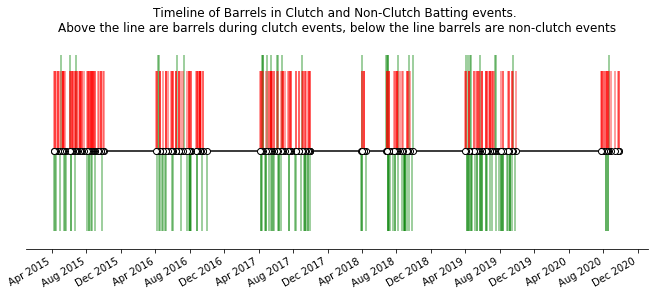

In [7]:
#plot that shit

import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(9, 4), constrained_layout=True)
ax.set(title="Timeline of Barrels in Clutch and Non-Clutch Batting events. \
\nAbove the line are barrels during clutch events, below the line barrels are non-clutch events")

ax.vlines(dates, 0, levels, color=clevels, alpha=0.5)  # The vertical stems.
ax.plot(dates, np.zeros_like(dates), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.

# format xaxis with 4 month intervals
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.yaxis.set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.margins(y=0.1)
plt.show()

Index(['Unnamed: 0', 'index', 'pitch_type', 'game_date', 'release_speed',
       'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher',
       'events', 'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release

In [14]:
def ECA(EventSeriesX, EventSeriesY, delT, tau=0, ts1=None, ts2=None):
    """
    from: http://www.pik-potsdam.de/~donges/pyunicorn/_modules/pyunicorn/eventseries/eca.html
    Event coincidence analysis:
    Returns the precursor and trigger coincidence rates of two event series
    X and Y.

    :type EventSeriesX: 1D Numpy array
    :arg EventSeriesX: Event series containing '0's and '1's
    :type EventSeriesY: 1D Numpy array
    :arg EventSeriesY: Event series containing '0's and '1's
    :arg delT: coincidence interval width
    :arg int tau: lag parameter
    :rtype: list
    :return: [Precursor coincidence rate XY, Trigger coincidence rate XY,
          Precursor coincidence rate YX, Trigger coincidence rate YX]
    """

    # Count events that cannot be coincided due to tau and delT
    if not (tau == 0 and delT == 0):
        # Start of EventSeriesX
        n11 = np.count_nonzero(EventSeriesX[:tau+delT])
        # End of EventSeriesX
        n12 = np.count_nonzero(EventSeriesX[-(tau+delT):])
        # Start of EventSeriesY
        n21 = np.count_nonzero(EventSeriesY[:tau+delT])
        # End of EventSeriesY
        n22 = np.count_nonzero(EventSeriesY[-(tau+delT):])
    else:
        # Instantaneous coincidence
        n11, n12, n21, n22 = 0, 0, 0, 0
    # Get time indices
    if ts1 is None:
        e1 = np.where(EventSeriesX)[0]
    else:
        e1 = ts1[EventSeriesX]
    if ts2 is None:
        e2 = np.where(EventSeriesY)[0]
    else:
        e2 = ts2[EventSeriesY]
    del EventSeriesX, EventSeriesY, ts1, ts2
    # Number of events
    l1 = len(e1)
    l2 = len(e2)
    # Array of all interevent distances
    dst = (np.array([e1]*l2).T - np.array([e2]*l1))
    # Count coincidences with array slicing
    prec12 = np.count_nonzero(np.any(((dst - tau >= 0)
                              * (dst - tau <= delT))[n11:, :],
                              axis=1))
    trig12 = np.count_nonzero(np.any(((dst - tau >= 0)
                              * (dst - tau <= delT))
                              [:, :dst.shape[1]-n22],
                              axis=0))
    prec21 = np.count_nonzero(np.any(((-dst - tau >= 0)
                              * (-dst - tau <= delT))[:, n21:],
                              axis=0))
    trig21 = np.count_nonzero(np.any(((-dst - tau >= 0)
                              * (-dst - tau <= delT))
                              [:dst.shape[0]-n12, :],
                              axis=1))
    # Normalisation and output
    return (np.float32(prec12)/(l1-n11), np.float32(trig12)/(l2-n22),
            np.float32(prec21)/(l2-n21), np.float32(trig21)/(l1-n12))

In [340]:
#Set date range
# Select a season
#Drop duplicates
# Get max and min dates of clutch barrels and non-clutch barrels. 
    #Set min as minimum window, max as maximum window. 
#Create an empty dataframe of dates with start = min, end = max
#Populate the main dataframe with clutch and non-clutch barrels, producting two 
#Reduce to an array. 



In [418]:
def make_test(df):
    """Filters a DF to only include  batters for testing purposes """
    
    batter1 = 434158.0
    batter2 = 452234.0
    batter3 = 541645.0
    batter4 = 608369.0

    cond1 = df['batter']==batter1
    cond2 = df['batter']==batter2
    cond3 = df['batter']==batter3
    cond4 = df['batter']==batter4

    return df[(cond1) | (cond2) | (cond3) | (cond4)]

def create_date_summary(df):
    """"Creates a summary view of the earliet and latest clutch event for a given player
    for a given year"""
    
    df1 = df.groupby(['batter','year']).agg([min, max]).reset_index()
    df1.columns = ['batter', 'year', 'min', 'max']
    return df1

def get_max_min(df1, df2):
    
    df1_min = df1['min'].tolist()[0]
    df1_max = df1['max'].tolist()[0]
    
    df2_min = df2['min'].tolist()[0]
    df2_max = df2['max'].tolist()[0]
    
    if df1_min < df2_min:
        g_min = df1_min
    else:
        g_min = df2_min
        
    if df1_max > df2_max:
        g_max = df1_max
    else:
        g_max = df2_max
        
    return [g_min, g_max]



def ECA_formatter(cdr, ncdr, c_dates, nc_dates):

    res_df = pd.DataFrame({
                "batter":[],
                "year": [],
                "c_barrels":[],
                "nc_barrels":[]
            })

    batter_list = [batter for batter in cdr['batter'].unique()]

    #Iterate through batters
    k = 0
    if len(batter_list) > 100:
        counter = True
        
    interval = len(batter_list) // 10 
    print('Processing records...')
    for batter in batter_list:

        fil1 = c_dates['batter']==batter
        fil2 = nc_dates['batter']==batter
        
        #Create lists of the dates that barrels occured for that batter
        cl_events = c_dates[fil1]['game_date'].tolist()
        ncl_events = nc_dates[fil2]['game_date'].tolist()

        #create year list
        cbdf = cdr[cdr['batter']==batter]['year'].unique()
        ncbdf = ncdr[ncdr['batter']==batter]['year'].unique()
        c_y1 = [yr for yr in cbdf]
        nc_y1 = [yr for yr in ncbdf]
        
        year_list = [yr for yr in c_y1]
        
        for y1 in nc_y1:
            if y1 not in year_list:
                year_list.append(y1)
                
        #For each season
        for yr in year_list:   

            #Filter the df with the max and min barrel date ranges by batter and eason
            df1 = cdr[(cdr['batter']==batter) & (cdr['year']==yr)]
            df2 = ncdr[(ncdr['batter']==batter) & (ncdr['year']==yr)]

            #get the earliest and last barrel dates, create a dataframe of days within the range
            if yr not in c_y1:
                arg1 = df2
                arg2 = df2
            elif yr not in nc_y1:
                arg1 = df1
                arg2 = df1
            else:
                arg1 = df1
                arg2 = df2
            
            mm_list = get_max_min(arg1,arg2)
            start = mm_list[0]
            end = mm_list[1]
            period_df = pd.date_range(start, end).to_list()

            #Now we create two arrays of spacing days, which have True if a barrel was hit on that day
            #and False if a barrel wasn't hit on that day. We do this for clutch and non-clutch events. 

            cl_list = [period_df[n] in cl_events for n in range(len(period_df))]
            ncl_list = [period_df[n] in ncl_events for n in range(len(period_df))]
            
            cl_arr = np.asarray(cl_list) * np.ones(len(cl_list))
            ncl_arr = np.asarray(ncl_list) * np.ones(len(ncl_list))

            new_row = pd.DataFrame({
                "batter":[batter],
                "year": [yr],
                "c_barrels":[cl_arr],
                "nc_barrels":[ncl_arr]
            })

            res_df = res_df.append(new_row, ignore_index = True)
        
        if counter:
            if k % interval == 0:
                print(f"{k} of {len(batter_list)} batters processed...")
        k += 1


    return res_df

def Q_ECA(row, delT, method='mean'):
    
    arg1 = row['c_barrels']
    arg2 = row['nc_barrels']
    
    try:
        #We look at the bidirectional trigger coincidences.
        res = ECA(arg1, arg2, delT)
        fwd = res[2]
        bwd = res[3]
    except:
        fwd = np.nan
        bwd = np.nan
    
    if np.isnan(fwd):
        if np.isnan(bwd):
            return None
        else:
            return bwd
    else:
        if method == 'mean':
            return (fwd + bwd) / 2
        elif method == 'max':
            return max(fwd, bwd)

In [397]:
#Define main columns we need
cols = ['game_date', 'year', 'batter']

#Take only barrel events and return only columns we need.
clutch_barrels_df = clutch_df[clutch_df['launch_speed_angle']==6][cols]
not_clutch_barrels_df = not_clutch_df[not_clutch_df['launch_speed_angle']==6][cols]

#Create a dataframe for the earliest and latest barrel in clutch and non-clutch situations. 
clutch_date_range = create_date_summary(clutch_barrels_df)
nclutch_date_range = create_date_summary(not_clutch_barrels_df)

#Create clutch df
event_df = ECA_formatter(clutch_date_range, nclutch_date_range, clutch_barrels_df, not_clutch_barrels_df)

event_df.head()

Processing records...
0 of 752 batters processed...
75 of 752 batters processed...
150 of 752 batters processed...
225 of 752 batters processed...
300 of 752 batters processed...
375 of 752 batters processed...
450 of 752 batters processed...
525 of 752 batters processed...
600 of 752 batters processed...
675 of 752 batters processed...
750 of 752 batters processed...


,batter,year,c_barrels,nc_barrels
0,116338.0,2015,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
1,120074.0,2015,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
2,120074.0,2016,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, ..."
3,121347.0,2015,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ..."
4,121347.0,2016,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


In [441]:
delT_list = [1, 7, 14, 28]
    
for delT in delT_list:
    event_df[f'Q_ECA_{delT}'] = event_df.apply(lambda x: Q_ECA(x, delT), axis = 1)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide


In [442]:
fil_df = event_df.dropna()
k = len(event_df)-len(event_df.dropna())
print(f'{k} of {len(event_df)} rows dropped')

1156 of 2747 rows dropped


In [443]:
cols = ['batter', 'Q_ECA_1', 'Q_ECA_7','Q_ECA_14','Q_ECA_28']
mean_event_df = event_df[cols].groupby('batter').agg('mean')

In [444]:
mean_event_df

,Q_ECA_1,Q_ECA_7,Q_ECA_14,Q_ECA_28
batter,,,,
116338.0,0.000000,0.000000,0.000000,0.000000
120074.0,0.249568,0.613511,0.707329,0.803842
121347.0,0.229412,0.636364,0.709677,0.892857
133380.0,0.000000,0.333333,0.676471,0.866667
134181.0,0.069444,0.359126,0.605042,0.777182
...,...,...,...,...
670541.0,0.290000,0.630435,0.681818,0.750000
670712.0,0.000000,0.500000,0.500000,NaN
671277.0,0.000000,1.000000,1.000000,NaN


In [445]:
## Data Cleaning and Checks
#drop empty values:
clutch_df = clutch_df.dropna(how='any', subset=['launch_speed_angle'])
not_clutch_df = not_clutch_df.dropna(how='any', subset=['launch_speed_angle'])

#sanity_check:
#clutch_df.launch_speed_angle.agg(['unique','count'])
#not_clutch_df.launch_speed_angle.agg(['unique','count'])

#Group by batter
clutch_by_batter = clutch_df.groupby("batter")
nclutch_by_batter = not_clutch_df.groupby("batter")

#OK let's now see what percentage of batted events were Barrelled (6)

cb_batter = clutch_by_batter['launch_speed_angle'].agg([
    ('events','count'),
    ('clutch_bar%', lambda x: sum(x == 6)/x.count()*100)
]).sort_values(
    by = 'events',
    ascending = False
)

#Compare this to non-clutch situations
ncb_batter = nclutch_by_batter['launch_speed_angle'].agg([
    ('nc_events','count'),
    ('nclutch_bar%', lambda x: sum(x == 6)/x.count()*100)
]).sort_values(
    by = 'nc_events',
    ascending = False
)

#Let's filter only for players who have more faced a certain 
#amount of clutch and non-clutch situations:
min_events = 200
print("There are a total of {} players, we will filter to the experienced guys \
\nwho have recorded clutch batting events at least {} times".format(len(cb_batter),min_events))

#Filter
cb_batter = cb_batter[cb_batter['events'] > min_events]
ncb_batter = ncb_batter[ncb_batter['nc_events'] > min_events]
print("Now we have {} players".format(len(cb_batter)))

#Join the dataframes on the player index
bar_comb = pd.merge(cb_batter,
                    ncb_batter, 
                    left_index = True, 
                    right_index = True, 
                    how = 'left'
                   )

#Let's create some new columns which is the differences:
bar_comb['bar%_delta'] = bar_comb['clutch_bar%'] - bar_comb['nclutch_bar%']

#add in names by joining with the name dataframe
bar_comb = bar_comb.reset_index()
bar_comb = pd.merge(bar_comb, names, left_on = 'batter', right_on = 'MLBCODE', how = 'left')
#bar_comb.head(20)

#Some formatting
bar_comb = bar_comb[['bar%_delta','Name','batter']].sort_values(by = 'bar%_delta', ascending = False)

#Let's get some stats
bar_av = bar_comb['bar%_delta'].mean()
bar_med = bar_comb['bar%_delta'].median()
bar_std = bar_comb['bar%_delta'].std()

There are a total of 1260 players, we will filter to the experienced guys 
who have recorded clutch batting events at least 200 times
Now we have 177 players


In [446]:
summary_df = bar_comb.merge(
    mean_event_df, 
    left_on = 'batter',
    right_on = 'batter',
    how = 'left'
)

In [447]:
summary_df

,bar%_delta,Name,batter,Q_ECA_1,Q_ECA_7,Q_ECA_14,Q_ECA_28
0,4.430667,Avisail Garcia,541645.0,0.234892,0.469590,0.664371,0.817916
1,4.228821,Matt Wieters,446308.0,0.017692,0.513462,0.658608,0.804350
2,4.106280,Justin Smoak,475253.0,0.074487,0.482782,0.653895,0.853469
3,4.005494,Chris Davis,448801.0,0.249575,0.514701,0.666231,0.819537
4,3.452431,Tim Anderson,641313.0,0.087698,0.367019,0.486667,0.719185
...,...,...,...,...,...,...,...
172,-3.960939,C.J. Cron,543068.0,0.271808,0.611246,0.703148,0.813168
173,-3.976761,Mark Trumbo,444432.0,0.140828,0.347147,0.571389,0.710327
174,-4.166829,Nelson Cruz,443558.0,0.363973,0.636269,0.723849,0.904900
175,-4.276317,Mike Trout,545361.0,0.316097,0.635269,0.721793,0.841717


Clutch vs Non-Clutch Barrel% difference  vs Clutch vs Non-Clutch Barrel Synchrony
 1 day Synchrony


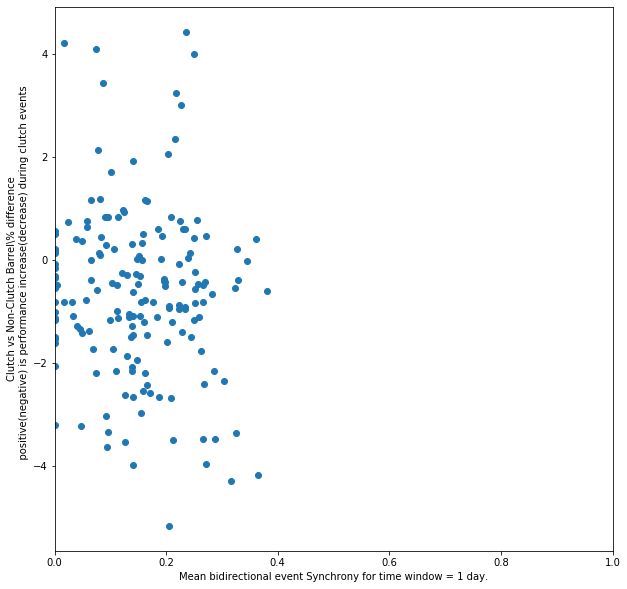

In [457]:
#plot 1
f = 1
col = f'Q_ECA_{f}'
y = summary_df['bar%_delta']
x1 = summary_df[col]

plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(x1,y)
plt.ylabel('Clutch vs Non-Clutch Barrel\% difference\n\
    positive(negative) is performance increase(decrease) during clutch events')
plt.xlabel(f'Mean bidirectional event Synchrony for time window = {f} day.')
plt.xlim(0, 1)
print(f"Clutch vs Non-Clutch Barrel% difference  vs Clutch vs Non-Clutch Barrel Synchrony\
\n {f} day Synchrony")

Clutch vs Non-Clutch Barrel% difference  vs Clutch vs Non-Clutch Barrel Synchrony
 7 day Synchrony


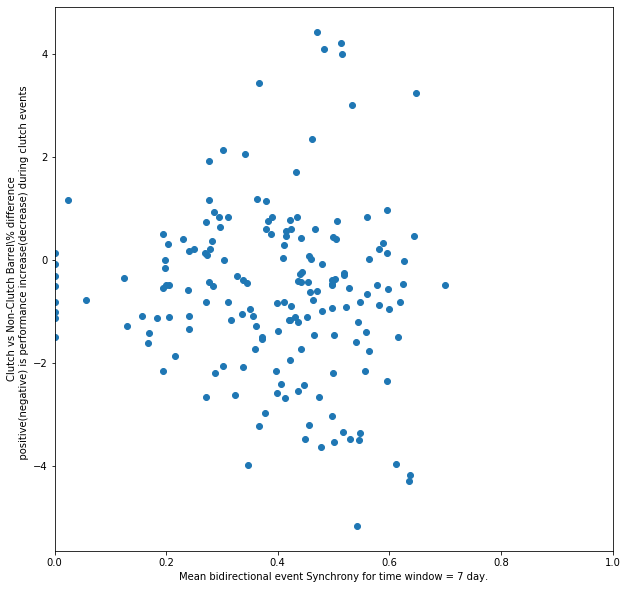

In [456]:
#plot 2
f = 7
col = f'Q_ECA_{f}'
y = summary_df['bar%_delta']
x1 = summary_df[col]

plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(x1,y)
plt.ylabel('Clutch vs Non-Clutch Barrel\% difference\n\
    positive(negative) is performance increase(decrease) during clutch events')
plt.xlabel(f'Mean bidirectional event Synchrony for time window = {f} day.')
plt.xlim(0, 1)
print(f"Clutch vs Non-Clutch Barrel% difference  vs Clutch vs Non-Clutch Barrel Synchrony\
\n {f} day Synchrony")

Clutch vs Non-Clutch Barrel% difference  vs Clutch vs Non-Clutch Barrel Synchrony
 14 day Synchrony


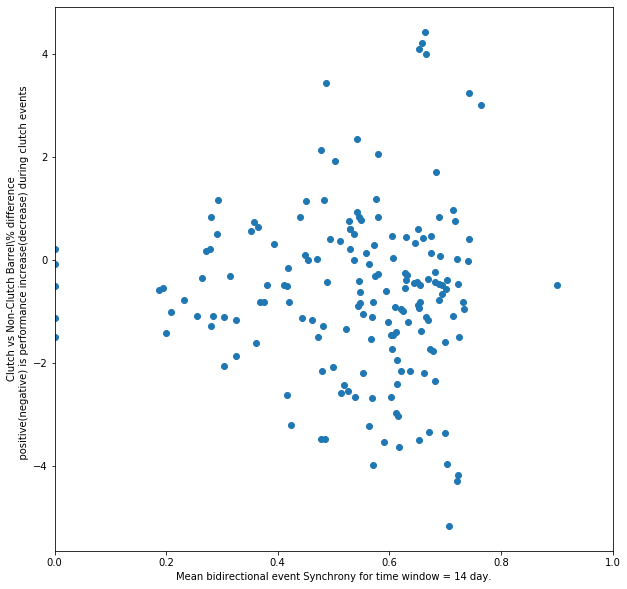

In [459]:
#plot 3
f = 14
col = f'Q_ECA_{f}'
y = summary_df['bar%_delta']
x1 = summary_df[col]

plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(x1,y)
plt.ylabel('Clutch vs Non-Clutch Barrel\% difference\n\
    positive(negative) is performance increase(decrease) during clutch events')
plt.xlabel(f'Mean bidirectional event Synchrony for time window = {f} day.')
plt.xlim(0, 1)
print(f"Clutch vs Non-Clutch Barrel% difference  vs Clutch vs Non-Clutch Barrel Synchrony\
\n {f} day Synchrony")

Clutch vs Non-Clutch Barrel% difference  vs Clutch vs Non-Clutch Barrel Synchrony
 28 day Synchrony


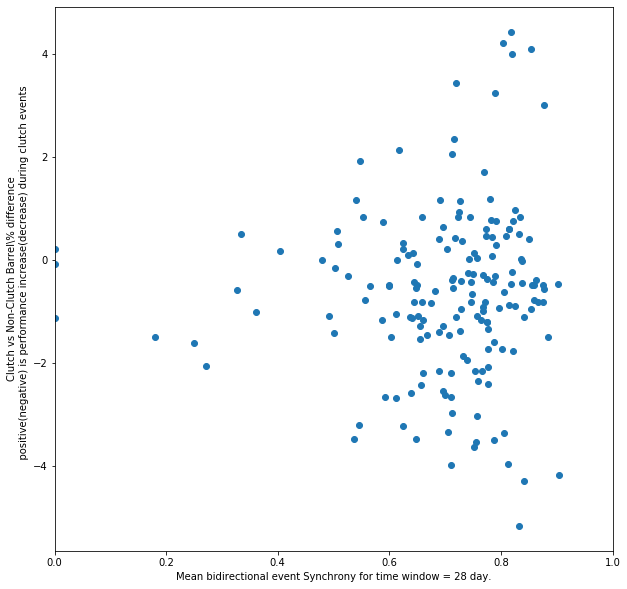

In [460]:
#plot 4
f = 28
col = f'Q_ECA_{f}'
y = summary_df['bar%_delta']
x1 = summary_df[col]

plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(x1,y)
plt.ylabel('Clutch vs Non-Clutch Barrel\% difference\n\
    positive(negative) is performance increase(decrease) during clutch events')
plt.xlabel(f'Mean bidirectional event Synchrony for time window = {f} day.')
plt.xlim(0, 1)
print(f"Clutch vs Non-Clutch Barrel% difference  vs Clutch vs Non-Clutch Barrel Synchrony\
\n {f} day Synchrony")